(differential-analysis)=
# Differential gene expression analysis

## Motivation

This chapter is a more detailed continuation of the Annotation subchapter which already introduced differential gene expression (DGE) as a tool to annotate clusters with cell types.
Here, we focus on more advanced use-cases of differential gene expression testing on more complex experimental designs which involve one or more conditions such as diseases, genetic knockouts or drugs.
In such cases we are commonly interested in the magnitude and significance of differences in gene expression patterns between the condition of interest and a reference. This reference can be everything but is commonly a healthy sample. This statistical test can be applied to arbitrary groups, but in the case of single-cell RNA-Seq is commonly applied on the cell type level.

:::{figure-md} Differential gene expression overview
<img src="../_static/images/conditions/differential_gene_expression.jpg" alt="DGE analysis overview" class="bg-primary mb-1" width="800px">

Differential gene expression analysis attempts to infer genes that are statistically significantly over- or underexpressed between any compared groups (commonly between healthy and condition per cell type).
:::

The outcome of such an analysis could be genesets which effect and potentially explain any observed phenotypes. These genesets can then be examined more closely with respect to, for example, affected pathways or induced cell-cell communication changes.

A differential gene expression test usually returns the log2 fold-change and the adjusted p-value per compared genes per compared conditions. This list can then be sorted by p-value and investigated in more detail.

The popular student's t-test is one way of conducting such a test. However, it fails to take several single-cell RNA-seq peculiarities into account such as the excess number of zeros originating from dropouts or the need for complex experimental designs. More specifically, very rarely does one have sufficient sample numbers to accurately estimate the variance without pooling information across genes. Moreover, raw counts are never an absolute measurement of expression for a specific gene within a given sample. The actual read number per gene depends on the efficiency of the library preparation, the amount of contamination from non-coding transcripts and the sequencing depth. It does therefore lack in both, sensitivity and specificity for single-cell RNA-seq, let alone experimental design flexibility.

As a result, differential gene expression testing is a classic bioinformatics problem which has been tackled by many tools already. Generally, the problem is currently being approached from two views, the sample-level view where expression is aggregated to create “pseudobulks” and then analysed with methods originally designed for bulk expression samples such as edgeR{cite}`de:Robinson2010` or DEseq2{cite}`Love2014` and the cell-level view where cells are modeled individually using generalized mixed effect models such as MAST{cite}`Finak2015` or glmmTMB{cite}`Brooks2017`. The consensus and robustness across datasets for DGE tools is low {cite}`Wang2019, Das2021`. As previously described, although single-cell data contains technical noise artifacts such as dropout, zero-inflation and high cell-to-cell variability {cite}`Hicks2017, Vallejos2017, de:Lücken2019`, methods designed for bulk {term}`RNA`-seq data performed favorably compared to methods explicitly designed for scRNA-seq data{cite}`Das2021, Soneson2018, Jaakkola2016, de:Squair2021`. Single-cell specific methods were found to be especially prone to wrongly labeling highly expressed genes as differentially expressed12.

A recent study highlighted the issue of pseudoreplication where inferential statistics is applied to biological replicates which are not statistically independent. Failing to account for the inherent correlation of replicates (cells from the same individual) inflates the false discovery rate (FDR){cite}`de:Squair2021, Zimmerman2021, Junttila2022`. Therefore, batch effect correction or the aggregation of cell-type-specific expression values within an individual through either a sum, mean or random effect per individual, that is pseudobulk generation, should be applied prior to DGE analysis to account for within-sample correlations {cite}`Zimmerman2021`. Generally, both, pseudobulk methods with sum aggregation such as edgeR, DESeq2, or Limma{cite}`Ritchie2015` and mixed models such as MAST with random effect setting were found to be superior compared to naive methods, such as the popular Wilcoxon rank-sum test or Seurat’s {cite}`de:Hao2021` latent models, which do not account for them{cite}`Junttila2022`.

In a matters arising to the Zimmerman paper, Murphy et al. critically examined the Zimmerman benchmarking strategy and improved it {cite}`Murphy_2022`. They come to the conclusion that pseudobulk methods perform best but whether sum or mean aggregation works better requires further investigation.

Hence, in this notebook, we demonstrate how to use two tools for DE analysis: edgeR with a quasi likelihood test and MAST with random effects. Since both edgeR and MAST are implemented in R, we use the anndata2ri package to be able to simultaneously work with AnnData objects in Python and SingeCellExperiment objects in R.

For each of the two methods, we show two use cases: how to run the analysis on full data and perform testing on multiple cell types and on one specific cell type.

## Environment setup

In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import decoupler as dc
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython
%matplotlib inline

During startup - Warning message:
Setting LC_CTYPE failed, using "C" 


In [2]:
%%R
library(edgeR)
library(MAST)

## Preparing the dataset

We will use the Kang dataset, which is a 10x droplet-based scRNA-seq peripheral blood mononuclear cell (PBMC) data from 8 Lupus patients before and after 6h-treatment with INF-β (16 samples in total){cite}`de:kang2018`. Interferon beta is used in the form of natural fibroblast or recombinant preparations (interferon beta-1a and interferon beta-1b) and exerts antiviral and antiproliferative properties similar to those of interferon alpha. Interferon beta has been approved for the treatment of relapsing–remitting multiple sclerosis and secondary progressive multiple sclerosis. 

First, we load the full dataset.

In [3]:
adata = sc.read("kang.h5ad")
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

We will need `label` (which contains the condition label), `replicate` and `cell_type` columns of the `.obs`.

In [4]:
adata.obs[:5]

,nCount_RNA,nFeature_RNA,tsne1,tsne2,label,cluster,cell_type,replicate,nCount_SCT,nFeature_SCT,integrated_snn_res.0.4,seurat_clusters
index,,,,,,,,,,,,
AAACATACATTTCC-1,3017.0,877,-27.640373,14.966629,ctrl,9,CD14+ Monocytes,patient_1016,1704.0,711,1,1
AAACATACCAGAAA-1,2481.0,713,-27.493646,28.924885,ctrl,9,CD14+ Monocytes,patient_1256,1614.0,662,1,1
AAACATACCATGCA-1,703.0,337,-10.468194,-5.984389,ctrl,3,CD4 T cells,patient_1488,908.0,337,6,6
AAACATACCTCGCT-1,3420.0,850,-24.367997,20.429285,ctrl,9,CD14+ Monocytes,patient_1256,1738.0,653,1,1
AAACATACCTGGTA-1,3158.0,1111,27.952170,24.159738,ctrl,4,Dendritic cells,patient_1039,1857.0,928,12,12


We will need to work with raw counts so we check that `.X` indeed contains raw counts and put them into the `counts` layer of our AnnData object.

In [5]:
np.max(adata.X)

3828.0

In [6]:
adata.layers["counts"] = adata.X.copy()

We have 8 control and 8 disease patients.

In [7]:
print(len(adata[adata.obs["label"] == "ctrl"].obs["replicate"].cat.categories))
print(len(adata[adata.obs["label"] == "stim"].obs["replicate"].cat.categories))

8
8


We filter cells which have less than 200 genes and genes which were found in less than 3 cells for a rudimentary quality control.

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 24562 × 15701
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes'
    var: 'name', 'n_cells'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

## Pseudobulk

edgeR is a differential gene expression testing tool implemented in R which was initially designed for bulk gene expression data. It implements a wide range of statistical methodology based on the negative binomial distribution, empirical Bayes estimation, exact tests, generalized linear models (GLMs) and quasi-likelihood tests.

For more details please read the original publication{cite}`de:Robinson2010`.

Here, we will be using the quasi likelihood test because it accounts for the uncertainty of the dispersion estimates. In contrast, the exact test assumes that the estimated dispersion is the true value, which can result in some inaccuracy. Additionally, the quasi likelihood GLMs are more flexible when it comes to experimental design.

Since edgeR was introduced as a method for DE analysis for bulk data, we first need to create pseudobulk samples from our single-cell dataset. For each patient we create 1 pseudobulk sample per cell type by aggregating the cell from each subpopulation and taking the mean gene expression within that subpopulation.

If the data you are working with does not have replicates, it could be beneficial to create multiple (e.g. 2-3) pseudobulks per patient to account for patient variability. Here we chose to create 1 psudobulk per patient because for each patient we have 2 replicates, one control and one stimulated.


We strongly recommend to read this guide https://f1000research.com/articles/9-1444 on design matrices.

Regardless of whether we want to run the analysis only on a few cell subpopulations and fit a model for each one of them separately or fit one model for all of them, we first need to prepare the data, define a function to create pseudobulks and run the edgeR pipeline. First, let's prepare the data.

Since we need to create pseudobulks for each patient-condition combination, we first need to create such a column by concatenating `replicate` and `label`.

In [9]:
adata.obs["sample"] = [
    f"{rep}_{l}" for rep, l in zip(adata.obs["replicate"], adata.obs["label"])
]

We need to clean up the cell type names, i.e. replace spaces with underscores and remove + symbols, to avoid Python to R conversion issues.

In [10]:
adata.obs["cell_type"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type"]]
adata.obs["cell_type"] = [ct.replace("+", "") for ct in adata.obs["cell_type"]]

We need to set categorical metadata to be indeed categorical to create pseudobulks.

In [11]:
# adata.obs["replicate"] = adata.obs["replicate"].astype("category")
# adata.obs["label"] = adata.obs["label"].astype("category")
# adata.obs["sample"] = adata.obs["sample"].astype("category")
# adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")

Next, let's define the function we will use to fit an edgeR GLM:
- `fit_model` takes a SingleCellExperiment object as input, creates the design matrix and outputs the fitted GLM. We also output the edgeR object of class DGEList to do some exploratory data analysis (EDA).

In [12]:
%%R
fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$label)
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)
    y <- y[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create a vector that is concatentation of condition and cell type that we will later use with contrasts
    group <- paste0(colData(adata_)$label, ".", colData(adata_)$cell_type)
    replicate <- colData(adata_)$replicate
    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    design <- model.matrix(~ 0 + group + replicate)
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}

Now we can proceed to creating pseudobulks wih `decoupler` {cite}`de:Badia-i-Mompel2022`. In this notebook, we use the official Python reimplementation (https://github.com/saezlab/decoupler-py) of `decoupleR`. We need to pass the raw counts to edgeR, so we pass the `counts` layer to ensure the pseudo-replicates are created for raw counts.

In [13]:
# Get pseudo-bulk profile
adata_pb = dc.get_pseudobulk(adata, sample_col='sample', groups_col='cell_type', layer='counts', min_prop=0.2, min_smpls=3)

The validity of differential gene expression results highly depend on the capturement of the major axis of variations in the statistical model. Intermediate data exploration steps such as principal component analysis (PCA) or multidimensional scaling (MDS) on pseudobulk samples allow for the identification of the sources of variation and thus can guide the construction of corresponding design and contrast matrices that model the data{cite}`Law2020`. 

Failing to account for multiple sources of biological variability for experiments which include biological replicates will inflate the FDR{cite}`Thurman2021`,{cite}`Lähnemann2020`. While increasing the number of cells per individual increases the precision, it has a limited effect on the power for the detection of differences across individuals. Therefore, the best way to increase statistical power is to increase the number of independent experimental samples{cite}`Zimmerman2021`. 

Since our data has already been generated, we cannot further increase the number of independent experimental samples. Nevertheless, we will now explore our data to determine the major axes of variation to properly generate our design matrices.

We perform very basic EDA on the created pseudo-replicates to check if some patients/pseudobulks are outliers that we need to exclude not to bias the DE results. We save the raw counts in the `'counts'` layer, then normalize the counts and calculate the PCA coordinates for the normalized pseudobulk counts.

In [14]:
adata_pb.layers['counts'] = adata_pb.X.copy()

In [15]:
sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

Next, we look at created pseudo-replicates on a PCA plot and color by all the available metadata to see if there are any confounding factors that we might want to include in the design matrix. We also add a `lib_size` and `log_lib_size` columns to check if there is a correlation between library size and PC components.

In [16]:
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1)
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

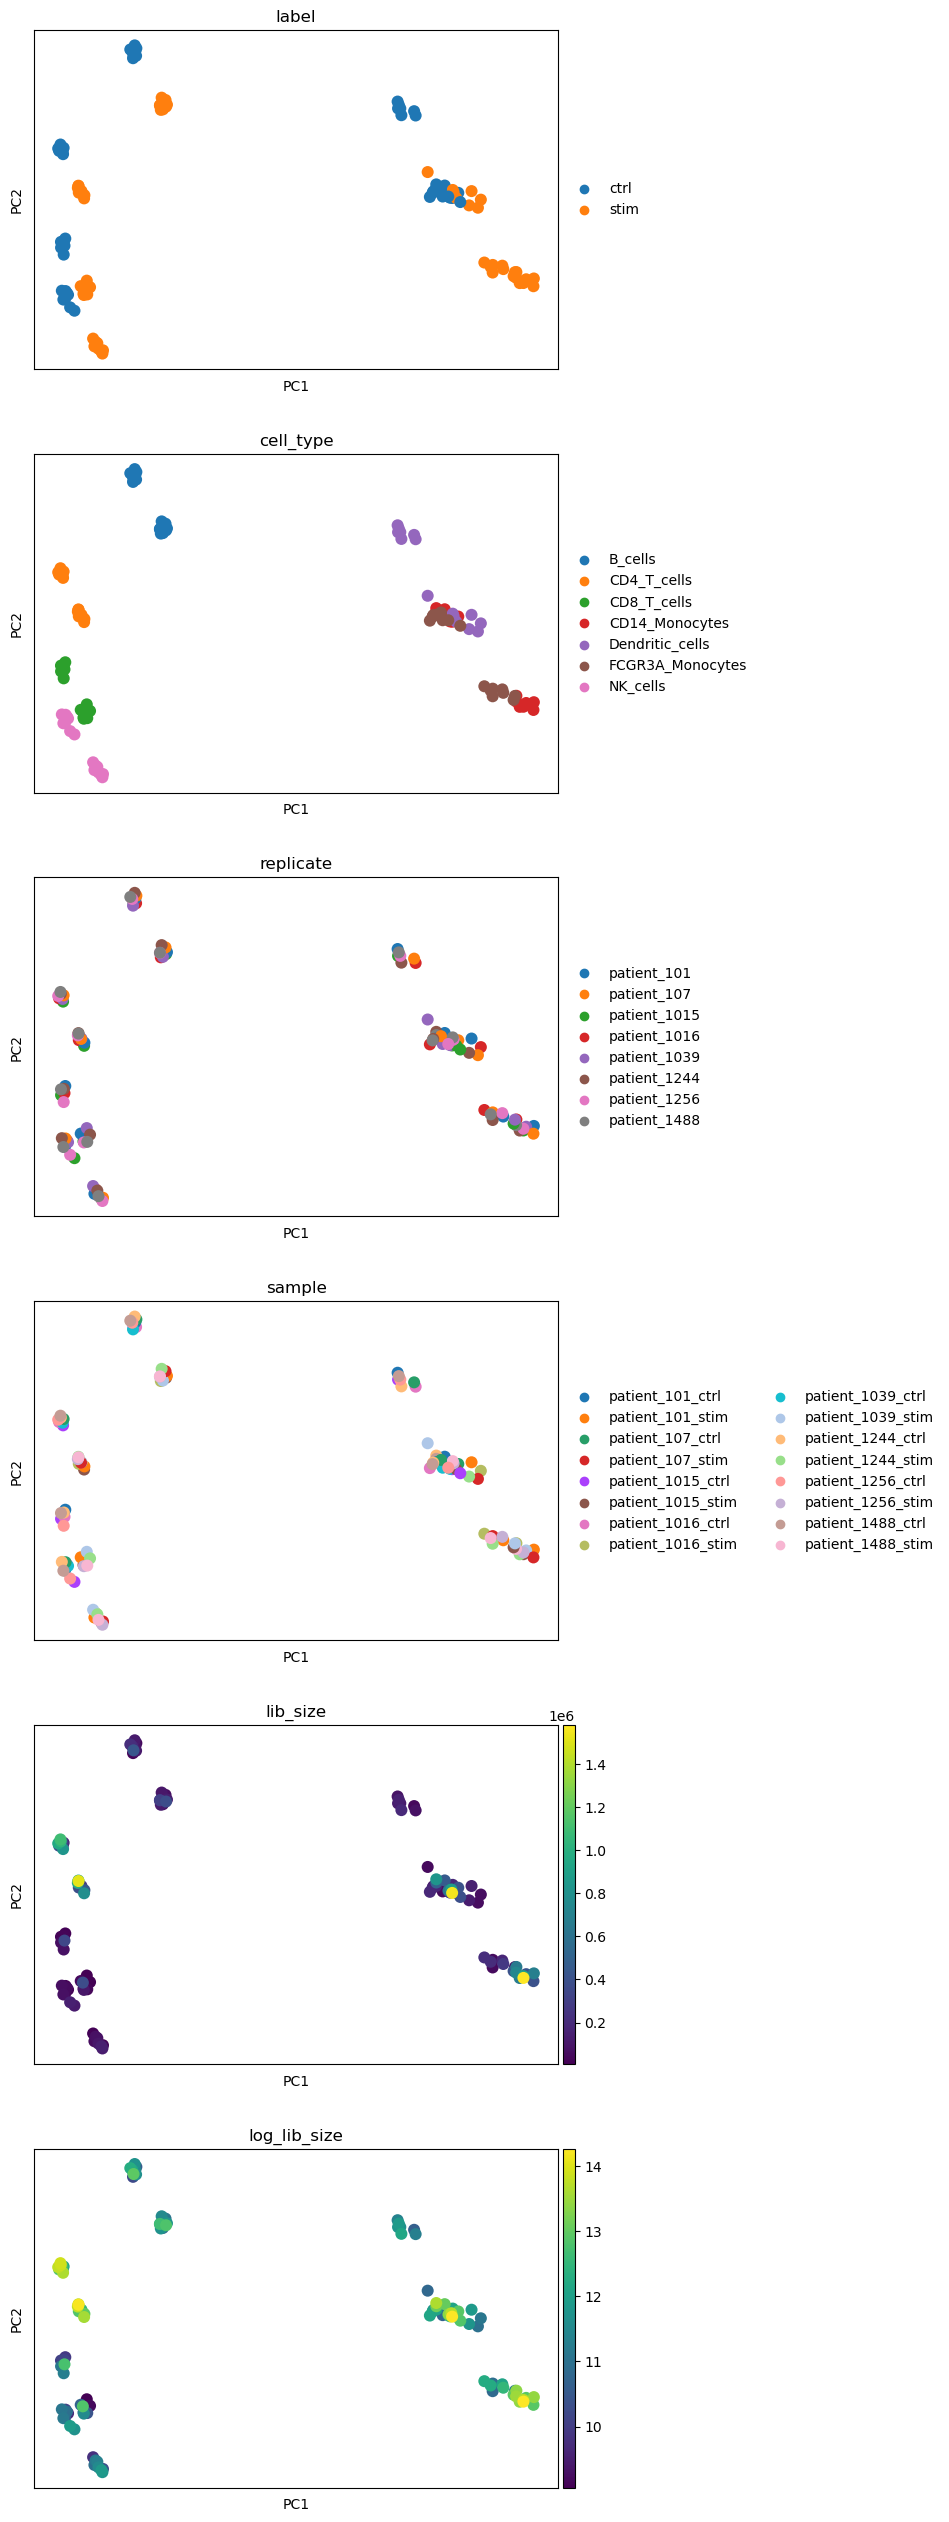

In [17]:
sc.pl.pca(adata_pb, color=adata_pb.obs, ncols=1, size=300)

We observe separation of cell types on the PCA plots as well as the separation into stimulated and unstimulated cells. Other covariates (batch) do not seem to be clearly correlated with the PCA components so we do not include any of them into our design matrix.

As mentioned above, edgeR takes raw couts as input, so we put counts back into the `.X` field before we proceed.

In [18]:
adata_pb.X = adata_pb.layers['counts'].copy()

### One group

First, we show how to prepare the data, construct the design matrix and perform the DE testing for one specific cell type.

We run the pipeline on CD14+ Monocytes subset of the data, as it was shown in the paper that the highest number of DE genes was indetified in this subpopulation.

In [19]:
adata_mono = adata_pb[adata_pb.obs["cell_type"] == "CD14_Monocytes"]
adata_mono

View of AnnData object with n_obs × n_vars = 16 × 2435
    obs: 'label', 'cell_type', 'replicate', 'sample', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca', 'label_colors', 'cell_type_colors', 'replicate_colors', 'sample_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

Clean the sample names to make plots less crowded.

In [20]:
adata_mono.obs_names = [
    name.split("_")[2] + "_" + name.split("_")[3] for name in adata_mono.obs_names
]

In [21]:
%%time
%%R -i adata_mono
outs <-fit_model(adata_mono)

[1] "Dimensions before subsetting:"
[1] 2435   16
[1] ""
[1] "Dimensions after subsetting:"
[1] 1226   16
[1] ""
CPU times: user 1.22 s, sys: 136 ms, total: 1.35 s
Wall time: 1.46 s


In [22]:
%%R
fit <- outs$fit
y <- outs$y

Since we did not enter our analysis with a prior assumption that a specific gene will be up- or downregulated, we need visualizations to make sense of the DGE results. MDS plots allow for a high level overview. Commonly, we expect a separation between samples from different conditions as can be seen in the following plot for our results.

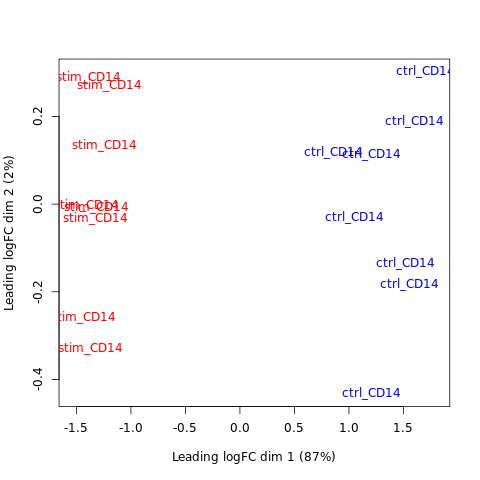

In [23]:
%%R
plotMDS(y, col=ifelse(y$samples$group == "stim", "red", "blue"))

Biological Coefficient of Variation (BCV) plots show the variability of every gene on average across biological groups as a function of mean expression. For example, bcv of 0.3 indicates that there is on average 30% percent variability in the expression of genes across groups.

Genes with low abundace generally exhibit larger BCV as read count measurements are more uncertain for low abundance genes. On the other hand, genes with high average expression are quantified more reliably, thus they generally have lower variability and hence lower BCV. Use this plot to detect outlier genes or pinpoint other experimental factors that may need to be reflected in the design matrix. For example, a group of genes with high average expression and high BCV appearing in the top right corner of the plot can flag experimental stress, contamination etc, particularly if they belong to similar gene families.

BCV is the square root of dispersion. The distance between tagwise and common bcv trend indicate if tagwise (gene-wise) dispersion estimates are highly variable (i.e. heterogenous gene expression). If tag-wise dispersion values are very heterogenous, less moderation is applied to capture heterogenity. The distance between any two points on those curves reflects how much the dispersion for a gene was shrunken towards the common trend. That is, it captures the amount of dispersion moderation applied.  

In the BCV plot below, we see some low abundance genes with high bcv, but no high abundance genes with high bcv, which indicates that there should not be any further experimental considerations modelled into the design matrix.

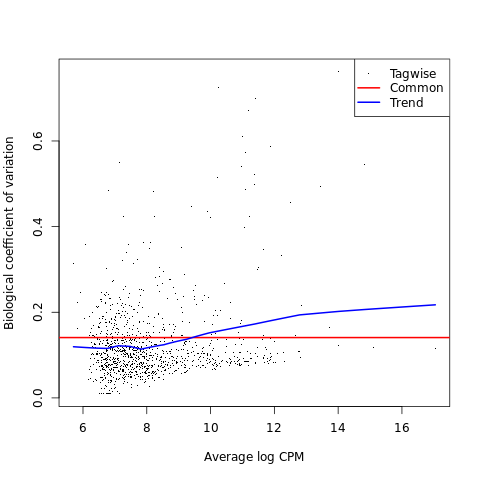

In [24]:
%%R
plotBCV(y)

Next, we perform the quasi-likelihood test to find DE genes between control and stimulated conditions. Let's check what columns our design matrix has to specify the correct columns to test on.

In [25]:
%%R
colnames(y$design)

[1] "groupctrl.CD14_Monocytes" "groupstim.CD14_Monocytes"
[3] "replicatepatient_107"     "replicatepatient_1015"   
[5] "replicatepatient_1016"    "replicatepatient_1039"   
[7] "replicatepatient_1244"    "replicatepatient_1256"   
[9] "replicatepatient_1488"   


In [26]:
%%R -o tt
myContrast <- makeContrasts('groupstim.CD14_Monocytes-groupctrl.CD14_Monocytes', levels = y$design)
qlf <- glmQLFTest(fit, contrast=myContrast)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table

Let's inspect the table: for each of the genes that were not filtered out by edgeR (3709 in our case), the table contains the results of the DE testing. The table can be saved as a `.csv` file to work with later and used for visualization. We will show how to use volcano plots at the end of the section after we run the analysis on full data.

In [27]:
tt.shape

(1226, 5)

In [28]:
tt[:5]

,logFC,logCPM,F,PValue,FDR
HESX1,8.200908,6.859081,1187.832808,1.925746e-12,6.296997e-10
NT5C3A,5.498712,8.401988,1182.908143,1.969303e-12,6.296997e-10
CD38,6.972991,7.501295,1173.002679,2.060498e-12,6.296997e-10
C19orf59,-5.064100,6.555775,1127.923698,2.544323e-12,6.296997e-10
SOCS1,4.231189,7.031771,1125.975126,2.568107e-12,6.296997e-10


As a side note, one can also test for genes that are differentially expressed for a provided coefficient or contrast relative to a specified fold-change using `glmTreat`.

In [29]:
%%R
tr <- glmTreat(fit, contrast=myContrast, lfc=1.5)
print(head(topTags(tr)))

Coefficient:  -1*groupctrl.CD14_Monocytes 1*groupstim.CD14_Monocytes 
          logFC unshrunk.logFC    logCPM       PValue          FDR
HESX1  8.200908       8.543184  6.859081 1.075609e-11 5.387262e-09
CD38   6.972991       7.061019  7.501295 1.146446e-11 5.387262e-09
NT5C3A 5.498712       5.515378  8.401988 1.318253e-11 5.387262e-09
DEFB1  6.497457       6.537452  8.140573 1.929160e-11 5.912876e-09
GMPR   6.791074       6.890307  7.119881 2.636829e-11 6.324333e-09
IL1RN  6.425468       6.433158 10.423033 3.095106e-11 6.324333e-09


And finally, we can see how many genes we have with FDR-corrected values of less than 0.01.

The smear plot (also known as MA, M-values vs A-values, plot) shows the log fold-change of the genes as a function of their mean abundance. We generally observe higher logFC at low abundance ranges as read counts are more variable at low abundance resulting in large logFC estimates. If we fit a loess curve to logFC and Average logCPM values, the trend should center around zero. Any deviations from this can indicate that data has not been properly normalised. Genes with large mean expression and large logFC in absolute values can flag biologically interesting genes for investigation and follow-up.

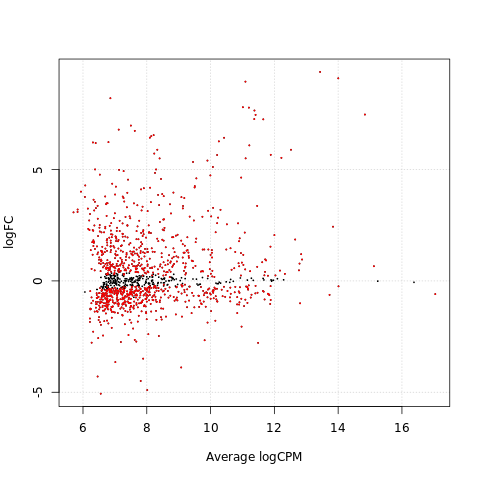

In [30]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR<0.01)])

### Multiple groups

Next, we show how to prepare the data, construct the design matrix and perform the DE testing using contrasts on the full dataset for all available cell types.

In [31]:
%%time
%%R -i adata_pb
outs <-fit_model(adata_pb)

[1] "Dimensions before subsetting:"
[1] 2435  108
[1] ""
[1] "Dimensions after subsetting:"
[1] 1034  108
[1] ""
CPU times: user 7.44 s, sys: 58.7 ms, total: 7.5 s
Wall time: 7.51 s


In [32]:
%%R
fit <- outs$fit
y <- outs$y

Now we use contrasts to perform a quasi-likelihood test for each of our cell types. Because there is no straightforward way to move tables from R to Python from within an R loop we get the results manually for each cell type.

In [33]:
%%R -i adata_pb -o de_per_cell_type
de_per_cell_type <- list()
for (cell_type in unique(colData(adata_pb)$cell_type)) {
    print(cell_type)
    # create contrast for this cell type
    myContrast <- makeContrasts(paste0("groupstim.", cell_type, "-groupctrl.", cell_type), levels = y$design)
    # perform QLF test
    qlf <- glmQLFTest(fit, contrast=myContrast)
    # get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
    tt <- topTags(qlf, n = Inf)
    # save in the list with the results for all the cell types
    de_per_cell_type[[cell_type]] <- tt$table
}

[1] "B_cells"
[1] "CD14_Monocytes"
[1] "CD4_T_cells"
[1] "CD8_T_cells"
[1] "Dendritic_cells"
[1] "FCGR3A_Monocytes"
[1] "NK_cells"


Now let's and save it in `.uns` of our original `adata` object using `sc_toolbox.tools.de_res_to_anndata` from `sc_toolbox` package (https://github.com/schillerlab/sc-toolbox), which saves the results as if they were created with the scanpy's `rank_genes_groups()` function. The advantage of storing the DE tables like this is that we could now also use standard scanpy plotting functions. We save the DEG tables as `.csv` for each cell type as we will need them later in the cell-to-cell communication chapter.

In [34]:
# get cell types that we ran the analysis for
cell_types = de_per_cell_type.keys()
# add the table to .uns for each cell type
for cell_type in cell_types:
    df = de_per_cell_type[cell_type]
    df["gene_symbol"] = df.index
    df["cell_type"] = cell_type
    sc_toolbox.tools.de_res_to_anndata(
        adata,
        df,
        groupby="cell_type",
        score_col="logCPM",
        pval_col="PValue",
        pval_adj_col="FDR",
        lfc_col="logFC",
        key_added="edgeR_" + cell_type,
    )
    df.to_csv(f"de_edgeR_{cell_type}.csv")

To get the table as a `pandas` DataFrame again, we use `sc.get.rank_genes_groups_df` function.

In [35]:
sc.get.rank_genes_groups_df(adata, group="CD14_Monocytes", key="edgeR_CD14_Monocytes")[
    :5
]

,names,scores,logfoldchanges,pvals,pvals_adj
0,FTH1,16.421707,-0.632895,0.00152,0.002491
1,MALAT1,16.246124,-0.042894,0.564013,0.683692
2,B2M,15.692309,0.627469,0.0,0.0
3,TMSB4X,15.325178,-0.272511,0.007495,0.01155
4,FTL,15.09798,-0.096701,0.419753,0.525476


### Notes on edgeR:
- Requires raw counts as input
- Requires pseudobulks from a single-cell experiment
- If there are several donors in the single-cell experiment and the user wants to account for the patient varianility, we recommend creating 2 or 3 pseudo-replicates for each patient and including patient information into the design matrix

## Single-cell specific

MAST models single-cell gene expression with a two-part generalized linear model. One part models the discrete expression rate of each gene across cells, whereas the other part models the conditional continuous expression level 

The MAST framework models single-cell gene expression using a two-part generalized linear model. One component of MAST models the discrete expression rate of each gene across cells, while the other component models the conditional continuous expression level (conditional on the gene being expressed).
For more details please read the original publication{cite}`Finak2015`.

MAST takes normalized counts as input, so we first take the 'counts' layer and then perform the normalization step.

In [36]:
adata.X = adata.layers["counts"].copy()

In [37]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

We define a small helper function that takes care of some object type conversion issue between R and Python. We also need to filter out genes that are expressed in a small number of cells (3 in this case) for each subpopulation as the model needs to be able to estimate the variance for each gene.

In [38]:
def prep_anndata(adata_):
    def fix_dtypes(adata_):
        df = pd.DataFrame(adata_.X.A, index=adata_.obs_names, columns=adata_.var_names)
        df = df.join(adata_.obs)
        return sc.AnnData(df[adata_.var_names], obs=df.drop(columns=adata_.var_names))

    adata_ = fix_dtypes(adata_)
    sc.pp.filter_genes(adata_, min_cells=3)
    return adata_

### One group

As with edgeR, it is possible to fit the model using the full dataset, and then use contrasts to perform the testing for each cell type of interest, but in this notebook we only show the MAST-RE pipeline for one cell type, namely CD14 Monocytes, to shorten the runtime.

In [39]:
adata_mono = adata[adata.obs["cell_type"] == "CD14_Monocytes"].copy()
adata_mono

AnnData object with n_obs × n_vars = 5696 × 15701
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes', 'sample'
    var: 'name', 'n_cells'
    uns: 'edgeR_B_cells', 'edgeR_CD14_Monocytes', 'edgeR_CD4_T_cells', 'edgeR_CD8_T_cells', 'edgeR_Dendritic_cells', 'edgeR_FCGR3A_Monocytes', 'edgeR_NK_cells', 'log1p'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [40]:
sc.pp.filter_genes(adata_mono, min_cells=3)
adata_mono

AnnData object with n_obs × n_vars = 5696 × 12268
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes', 'sample'
    var: 'name', 'n_cells'
    uns: 'edgeR_B_cells', 'edgeR_CD14_Monocytes', 'edgeR_CD4_T_cells', 'edgeR_CD8_T_cells', 'edgeR_Dendritic_cells', 'edgeR_FCGR3A_Monocytes', 'edgeR_NK_cells', 'log1p'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

Next we filter both objects as mentioned above.

In [41]:
adata_mono = prep_anndata(adata_mono)
adata_mono

AnnData object with n_obs × n_vars = 5696 × 12268
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes', 'sample'
    var: 'n_cells'

As is the case whenever multiple statistical tests are performed, the obtained p-values for DGE tests over conditions must be corrected for multiple testing using, for example, a Benjamini-Hochberg correction{cite}`de:Lücken2019`,{cite}`Benjamini1995`.

Similarly to edgeR analysis, we define a separate function that we use for the analysis:
- `find_de_MAST_RE` takes a SingleCellExperiment object as input and runs MAST with RE pipeline. The output of the function is table (pandas DataFrame in Python) which contains results of the analysis, e.g. log-fold change, p-value and FDR-corrected value for each gene.

In [42]:
adata_mono.obs["cell_type"] = [
    ct.replace(" ", "_") for ct in adata_mono.obs["cell_type"]
]
adata_mono.obs["cell_type"] = [
    ct.replace("+", "") for ct in adata_mono.obs["cell_type"]
]

In [43]:
%%R
find_de_MAST_RE <- function(adata_){
    # create a MAST object
    sca <- SceToSingleCellAssay(adata_, class = "SingleCellAssay")
    print("Dimensions before subsetting:")
    print(dim(sca))
    print("")
    # keep genes that are expressed in more than 10% of all cells
    sca <- sca[freq(sca)>0.1,]
    print("Dimensions after subsetting:")
    print(dim(sca))
    print("")
    # add a column to the data which contains scaled number of genes that are expressed in each cell
    cdr2 <- colSums(assay(sca)>0)
    colData(sca)$ngeneson <- scale(cdr2)
    # store the columns that we are interested in as factors
    label <- factor(colData(sca)$label)
    # set the reference level
    label <- relevel(label,"ctrl")
    colData(sca)$label <- label
    celltype <- factor(colData(sca)$cell_type)
    colData(sca)$celltype <- celltype
    # same for donors (which we need to model random effects)
    replicate <- factor(colData(sca)$replicate)
    colData(sca)$replicate <- replicate
    # create a group per condition-celltype combination
    colData(sca)$group <- paste0(colData(adata_)$label, ".", colData(adata_)$cell_type)
    colData(sca)$group <- factor(colData(sca)$group)
    # define and fit the model
    zlmCond <- zlm(formula = ~ngeneson + group + (1 | replicate), 
                   sca=sca, 
                   method='glmer', 
                   ebayes=F, 
                   strictConvergence=F,
                   fitArgsD=list(nAGQ = 0)) # to speed up calculations
    
    # perform likelihood-ratio test for the condition that we are interested in    
    summaryCond <- summary(zlmCond, doLRT='groupstim.CD14_Monocytes')
    # get the table with log-fold changes and p-values
    summaryDt <- summaryCond$datatable
    result <- merge(summaryDt[contrast=='groupstim.CD14_Monocytes' & component=='H',.(primerid, `Pr(>Chisq)`)], # p-values
                     summaryDt[contrast=='groupstim.CD14_Monocytes' & component=='logFC', .(primerid, coef)],
                     by='primerid') # logFC coefficients
    # MAST uses natural logarithm so we convert the coefficients to log2 base to be comparable to edgeR
    result[,coef:=result[,coef]/log(2)]
    # do multiple testing correction
    result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
    result = result[result$FDR<0.01,, drop=F]

    result <- stats::na.omit(as.data.frame(result))
    return(result)
}

We run the pipeline for monocytes.

In [44]:
%%time
%%R -i adata_mono -o res
res <-find_de_MAST_RE(adata_mono)

[1] "Dimensions before subsetting:"
[1] 12268  5696
[1] ""
[1] "Dimensions after subsetting:"
[1] 1676 5696
[1] ""
CPU times: user 9min 52s, sys: 3.25 s, total: 9min 55s
Wall time: 9min 58s


Let's take a look at the results.

In [45]:
res[:5]

,primerid,Pr(>Chisq),coef,FDR
1,AAED1,8.410341e-19,0.709836,1.597106e-18
2,ABI1,1.401688e-05,0.312797,1.824921e-05
3,ABRACL,3.920183e-06,0.418028,5.201004e-06
4,ACADVL,2.121110e-26,-0.751305,4.656979e-26
5,ACOT9,3.424174e-151,2.921133,2.689503e-150


We store the result in `.uns` as before. Note that we won't need the `score` column so we just pass logFC there.

In [46]:
res["gene_symbol"] = res["primerid"]
res["cell_type"] = "CD14_Monocytes"
sc_toolbox.tools.de_res_to_anndata(
    adata,
    res,
    groupby="cell_type",
    score_col="coef",
    pval_col="Pr(>Chisq)",
    pval_adj_col="FDR",
    lfc_col="coef",
    key_added="MAST_CD14_Monocytes",
)

In [47]:
adata_copy = adata.copy()

## Visualization

We can visualize the results with a heatmap and a volcano plot. Each row of a heatmap corresponds to a gene and each column to a single-cell. The brighter the color is the higher is the expresion of that gene in a particular cell. Since we only plot DE genes, we would like to see clear differences in expression between the two conditions. Volcano plots are often used to visualize results of statistical testing, and they show the change in expression on the x-axis (log-fold change) and statistical significance on the y-axis (FDR-corrected p-values). We color code the genes that have FDR-corrected p-value under 0.01 and log-fold change of over 1.5

We normalize the data before plotting the heatmaps to see the differences in expression between two conditions better.

In [48]:
adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

Next, we define a helper plotting function for the heatmaps.

In [49]:
FDR = 0.01
LOG_FOLD_CHANGE = 1.5


def plot_heatmap(adata, group_key, group_name="cell_type", groupby="label"):
    cell_type = "_".join(group_key.split("_")[1:])
    res = sc.get.rank_genes_groups_df(adata, group=cell_type, key=group_key)
    res.index = res["names"].values
    res = res[
        (res["pvals_adj"] < FDR) & (abs(res["logfoldchanges"]) > LOG_FOLD_CHANGE)
    ].sort_values(by=["logfoldchanges"])
    print(f"Plotting {len(res)} genes...")
    markers = list(res.index)
    sc.pl.heatmap(
        adata[adata.obs[group_name] == cell_type].copy(),
        markers,
        groupby=groupby,
        swap_axes=True,
    )

And finally we can plot the heatmaps with DEG for CD14+ Monocytes for both edgeR and MAST with RE.

Plotting 136 genes...


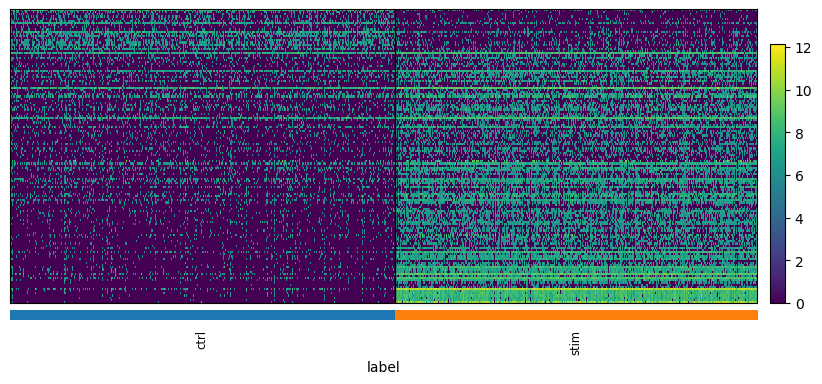

In [50]:
plot_heatmap(adata, "edgeR_CD14_Monocytes")

Plotting 436 genes...


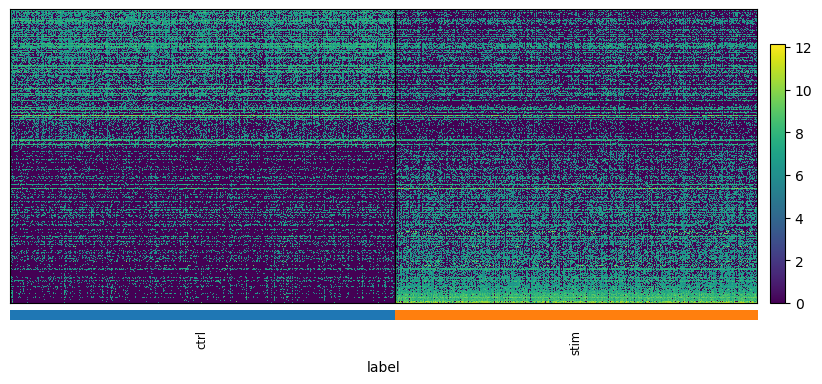

In [51]:
plot_heatmap(adata, "MAST_CD14_Monocytes")

We observe that MAST identified 436 DEG with our given cut-offs for adjusted p-values and logfold change, while edgeR indentified 303 genes.

Next, we define the helper plotting function for the volcano plots.

In [52]:
FDR = 0.01
LOG_FOLD_CHANGE = 1.5


def volcano_plot(adata, group_key, group_name="cell_type", groupby="label", title=None):
    cell_type = "_".join(group_key.split("_")[1:])
    result = sc.get.rank_genes_groups_df(adata, group=cell_type, key=group_key).copy()
    result["-logQ"] = -np.log(result["pvals"].astype("float"))
    lowqval_de = result.loc[abs(result["logfoldchanges"]) > LOG_FOLD_CHANGE]
    other_de = result.loc[abs(result["logfoldchanges"]) <= LOG_FOLD_CHANGE]

    fig, ax = plt.subplots()
    sns.regplot(
        x=other_de["logfoldchanges"],
        y=other_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    sns.regplot(
        x=lowqval_de["logfoldchanges"],
        y=lowqval_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    ax.set_xlabel("log2 FC")
    ax.set_ylabel("-log Q-value")

    if title is None:
        title = group_key.replace("_", " ")
    plt.title(title)
    plt.show()

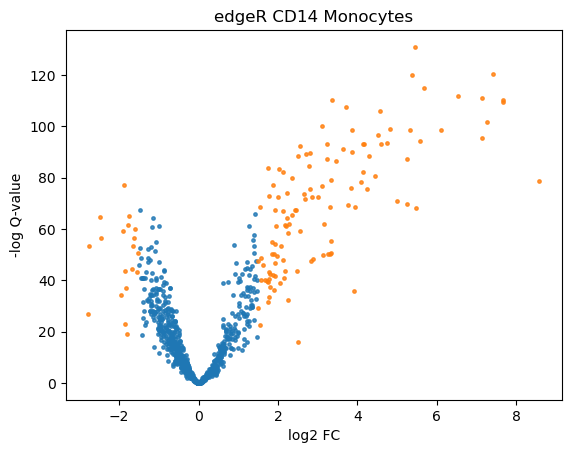

In [53]:
volcano_plot(adata, "edgeR_CD14_Monocytes")

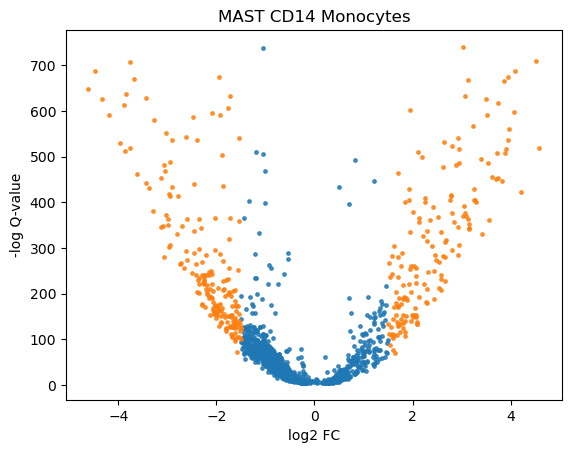

In [54]:
volcano_plot(adata, "MAST_CD14_Monocytes")

From the heatmaps and especially from the volcano plots, one can see that edgeR identified more up-regulated than down-regulated genes (in stimulated vs control) in contrast to MAST which identified similar number of up- and down-regulated genes.

## Key Takeaways

1. Repeated measurements (cells) from the same experimental subject in scRNA-seq introduce correlations between measurements, which need to be adjusted by modeling the experimental units as Random Effect to mitigate the pseudoreplication issue. Account for them through a sum or mean aggregation (pseudobulk methods - by fixed- or random effect terms) or by accounting for individual as a random effect (single-cell methods) to mitigate the pseudoreplication issue.
2. Determine the major axis of variation with exploratory analysis to construct an appropriate design matrix to better model the variations in the data.
3. Statistical power is best increased with more samples in the experimental design.

## Quiz

1. What is differential gene expression and in which cases are we interested in testing for it?

2. What is the 'pseudoreplication' problem and how can it be circumvented?

3. What is the 'multiple testing' problem and how can it be eluded?

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: de
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Lukas Heumos
* Anastasia Litinetskaya
* Soroor Hediyeh-Zadeh

### Reviewers